<h1>Deriving features and cross-correlation (time-lag) </h1>

<h2>Using a weather dataset as a example</h2>

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../input/sudeste.csv")

I will choose a especif weather station as an example.  **RIO DE JANEIRO** (weather station id: 384) and some **more recents records**

In [3]:
dfx = df[(df['wsid']==384) & (df['mdct'] > '2015-01-01 00:00:00')  ]
dfx.head(5)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
6842217,384,VILA MILITAR,30.0,-22.861322,-43.41141,A621,Rio de Janeiro,RJ,2015-01-01 01:00:00,2015-01-01,...,26.1,20.7,25.2,19.8,72.0,74.0,70.0,0.3,218.0,4.5
6842218,384,VILA MILITAR,30.0,-22.861322,-43.41141,A621,Rio de Janeiro,RJ,2015-01-01 02:00:00,2015-01-01,...,25.6,21.1,24.6,19.8,80.0,80.0,70.0,0.6,36.0,1.1
6842219,384,VILA MILITAR,30.0,-22.861322,-43.41141,A621,Rio de Janeiro,RJ,2015-01-01 03:00:00,2015-01-01,...,25.5,21.0,24.4,19.8,74.0,81.0,71.0,0.4,106.0,2.7
6842220,384,VILA MILITAR,30.0,-22.861322,-43.41141,A621,Rio de Janeiro,RJ,2015-01-01 04:00:00,2015-01-01,...,25.6,20.5,24.7,18.9,72.0,77.0,66.0,0.8,114.0,2.2
6842221,384,VILA MILITAR,30.0,-22.861322,-43.41141,A621,Rio de Janeiro,RJ,2015-01-01 05:00:00,2015-01-01,...,25.2,20.1,23.6,19.1,77.0,79.0,70.0,1.1,36.0,2.3


<h2>Cross-correlation (time-lag) using pandas</h2></h2>

Let's get focus in some features: 
* temp (temperature) 
* hmdy (relative humidity)

In [4]:
fields = ['mdct','temp','hmdy'] # mdct is datetime 
x = dfx[fields]
x.head(10)

,mdct,temp,hmdy
6842217,2015-01-01 01:00:00,25.6,72.0
6842218,2015-01-01 02:00:00,24.6,80.0
6842219,2015-01-01 03:00:00,24.8,74.0
6842220,2015-01-01 04:00:00,24.8,72.0
6842221,2015-01-01 05:00:00,24.1,77.0
6842222,2015-01-01 06:00:00,25.0,68.0
6842223,2015-01-01 07:00:00,26.1,59.0
6842224,2015-01-01 08:00:00,26.6,56.0
6842225,2015-01-01 09:00:00,26.9,57.0
6842226,2015-01-01 10:00:00,29.6,49.0


Imagine that you need to **correlate the temp** in t with t-1 (1 hour ago), t-2 (2 hours ago), ... t-n(n hours ago).  A good approach is **create a function** that shifted your dataframe first before calling the corr(). Let us break down what we hope to accomplish, and then translate that into code. For each hour (row) and for a given feature (column) I would like to find the value for that feature N hours prior. For each value of N (1-6 in our case) I want to make a new column for that feature representing the Nth prior hour's measurement.

In [5]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df

Suposing that you need to correlate 6 hours. 

In [6]:
NON_DER = ['mdct',]
df_new = df_derived_by_shift(x, 6, NON_DER)

In [7]:
df_new.head(10)

,mdct,temp,hmdy,temp_1,temp_2,temp_3,temp_4,temp_5,temp_6,hmdy_1,hmdy_2,hmdy_3,hmdy_4,hmdy_5,hmdy_6
6842217,2015-01-01 01:00:00,25.6,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6842218,2015-01-01 02:00:00,24.6,80.0,25.6,NaN,NaN,NaN,NaN,NaN,72.0,NaN,NaN,NaN,NaN,NaN
6842219,2015-01-01 03:00:00,24.8,74.0,24.6,25.6,NaN,NaN,NaN,NaN,80.0,72.0,NaN,NaN,NaN,NaN
6842220,2015-01-01 04:00:00,24.8,72.0,24.8,24.6,25.6,NaN,NaN,NaN,74.0,80.0,72.0,NaN,NaN,NaN
6842221,2015-01-01 05:00:00,24.1,77.0,24.8,24.8,24.6,25.6,NaN,NaN,72.0,74.0,80.0,72.0,NaN,NaN
6842222,2015-01-01 06:00:00,25.0,68.0,24.1,24.8,24.8,24.6,25.6,NaN,77.0,72.0,74.0,80.0,72.0,NaN
6842223,2015-01-01 07:00:00,26.1,59.0,25.0,24.1,24.8,24.8,24.6,25.6,68.0,77.0,72.0,74.0,80.0,72.0
6842224,2015-01-01 08:00:00,26.6,56.0,26.1,25.0,24.1,24.8,24.8,24.6,59.0,68.0,77.0,72.0,74.0,80.0
6842225,2015-01-01 09:00:00,26.9,57.0,26.6,26.1,25.0,24.1,24.8,24.8,56.0,59.0,68.0,77.0,72.0,74.0
6842226,2015-01-01 10:00:00,29.6,49.0,26.9,26.6,26.1,25.0,24.1,24.8,57.0,56.0,59.0,68.0,77.0,72.0


You will probably remember that I have** intentionally introduced missing values for the first six hours **of the data collected by deriving features representing the prior six hours of measurements. It is not until the sixth hour in that we can start deriving those features, so clearly I will want to exclude those first sixth hours from the data set.

In [8]:
df_new = df_new.dropna()

In [9]:
df_new.head(10)

,mdct,temp,hmdy,temp_1,temp_2,temp_3,temp_4,temp_5,temp_6,hmdy_1,hmdy_2,hmdy_3,hmdy_4,hmdy_5,hmdy_6
6842223,2015-01-01 07:00:00,26.1,59.0,25.0,24.1,24.8,24.8,24.6,25.6,68.0,77.0,72.0,74.0,80.0,72.0
6842224,2015-01-01 08:00:00,26.6,56.0,26.1,25.0,24.1,24.8,24.8,24.6,59.0,68.0,77.0,72.0,74.0,80.0
6842225,2015-01-01 09:00:00,26.9,57.0,26.6,26.1,25.0,24.1,24.8,24.8,56.0,59.0,68.0,77.0,72.0,74.0
6842226,2015-01-01 10:00:00,29.6,49.0,26.9,26.6,26.1,25.0,24.1,24.8,57.0,56.0,59.0,68.0,77.0,72.0
6842227,2015-01-01 11:00:00,31.6,41.0,29.6,26.9,26.6,26.1,25.0,24.1,49.0,57.0,56.0,59.0,68.0,77.0
6842228,2015-01-01 12:00:00,33.3,39.0,31.6,29.6,26.9,26.6,26.1,25.0,41.0,49.0,57.0,56.0,59.0,68.0
6842229,2015-01-01 13:00:00,36.1,35.0,33.3,31.6,29.6,26.9,26.6,26.1,39.0,41.0,49.0,57.0,56.0,59.0
6842230,2015-01-01 14:00:00,36.0,33.0,36.1,33.3,31.6,29.6,26.9,26.6,35.0,39.0,41.0,49.0,57.0,56.0
6842231,2015-01-01 15:00:00,38.7,29.0,36.0,36.1,33.3,31.6,29.6,26.9,33.0,35.0,39.0,41.0,49.0,57.0
6842232,2015-01-01 16:00:00,39.0,28.0,38.7,36.0,36.1,33.3,31.6,29.6,29.0,33.0,35.0,39.0,41.0,49.0


<h2>Cross-correlation: Finally </h2></h2>

In [10]:
df_new.corr()

,temp,hmdy,temp_1,temp_2,temp_3,temp_4,temp_5,temp_6,hmdy_1,hmdy_2,hmdy_3,hmdy_4,hmdy_5,hmdy_6
temp,1.000000,-0.511732,0.888855,0.819054,0.731786,0.629800,0.523577,0.416886,-0.555692,-0.494948,-0.411066,-0.312864,-0.210123,-0.111014
hmdy,-0.511732,1.000000,-0.558337,-0.494677,-0.403986,-0.299873,-0.191815,-0.085660,0.817130,0.713668,0.595964,0.467168,0.333565,0.209803
temp_1,0.888855,-0.558337,1.000000,0.888847,0.819041,0.731766,0.629775,0.523553,-0.511700,-0.555667,-0.494922,-0.411026,-0.312818,-0.210088
temp_2,0.819054,-0.494677,0.888847,1.000000,0.888839,0.819029,0.731749,0.629755,-0.558311,-0.511679,-0.555647,-0.494893,-0.410995,-0.312792
temp_3,0.731786,-0.403986,0.819041,0.888839,1.000000,0.888832,0.819018,0.731737,-0.494646,-0.558287,-0.511655,-0.555619,-0.494859,-0.410971
temp_4,0.629800,-0.299873,0.731766,0.819029,0.888832,1.000000,0.888825,0.819010,-0.403949,-0.494620,-0.558266,-0.511624,-0.555588,-0.494839
temp_5,0.523577,-0.191815,0.629775,0.731749,0.819018,0.888825,1.000000,0.888819,-0.299832,-0.403921,-0.494596,-0.558239,-0.511593,-0.555572
temp_6,0.416886,-0.085660,0.523553,0.629755,0.731737,0.819010,0.888819,1.000000,-0.191778,-0.299800,-0.403896,-0.494568,-0.558207,-0.511575
hmdy_1,-0.555692,0.817130,-0.511700,-0.558311,-0.494646,-0.403949,-0.299832,-0.191778,1.000000,0.817118,0.713655,0.595939,0.467136,0.333540
hmdy_2,-0.494948,0.713668,-0.555667,-0.511679,-0.558287,-0.494620,-0.403921,-0.299800,0.817118,1.000000,0.817111,0.713646,0.595930,0.467121


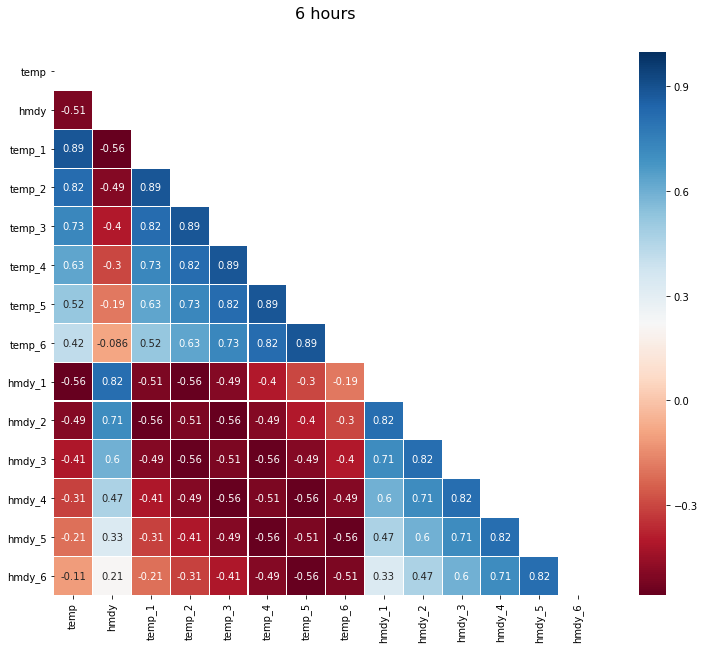

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
plt.title(u'6 hours', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()